In [1]:
%tensorflow_version 1.x

# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, concatenate
from keras.layers import GRU, Bidirectional, TimeDistributed
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import os
import re
import numpy as np
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_WINDOW = 7
W2V_EPOCH = 32

MAXLEN = 100
MAX_SENTENCES = 15
MAX_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# SENTIMENT
POSITIVE = 1
NEGATIVE = 0
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [0]:
tweets = [] 
labels = []
texts = []

In [0]:
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

# class defining the custom attention layer
class HierarchicalAttentionNetwork(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(HierarchicalAttentionNetwork, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim,)))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(HierarchicalAttentionNetwork, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))

        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [0]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/training.1600000.processed.noemoticon.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [0]:
sample = 200000
ndf = df.sample(sample, random_state=42)

In [0]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [0]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [10]:
%%time
ndf.text = ndf.text.apply(lambda x: preprocess(x))

CPU times: user 5.7 s, sys: 21.6 ms, total: 5.72 s
Wall time: 5.72 s


In [0]:
decode_map = {0: 0, 4: 1}
def decode_sentiment(label):
    return decode_map[int(label)]

In [12]:
%%time
ndf.target = ndf.target.apply(lambda x: decode_sentiment(x))

CPU times: user 108 ms, sys: 24 µs, total: 108 ms
Wall time: 107 ms


In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from nltk import tokenize

tweets = []
labels = []
texts = []

for idx, _ in ndf.iterrows():
    text = ndf.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    tweets.append(sentences)
    labels.append(ndf.target[idx])

In [15]:
from keras.preprocessing.text import text_to_word_sequence

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTENCES, MAXLEN), dtype='int32')

for i, sentences in enumerate(tweets):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTENCES:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                if k < MAXLEN and tokenizer.word_index[word] < MAX_WORDS:
                    data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1

word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 89145 unique tokens.


In [16]:
from keras.utils.np_utils import to_categorical

labels = to_categorical(np.asarray(labels))
print('Shape of reviews (data) tensor:', data.shape)
print('Shape of sentiment (label) tensor:', labels.shape)

Shape of reviews (data) tensor: (200000, 15, 100)
Shape of sentiment (label) tensor: (200000, 2)


In [0]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [18]:
print('Number of positive and negative reviews in training and validation set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Number of positive and negative reviews in training and validation set
[79790. 80210.]
[20067. 19933.]


In [19]:
embeddings_index = {}

f = open("/content/drive/My Drive/Colab Notebooks/glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [20]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAXLEN, trainable=True, mask_zero=True)

2020-04-05 08:39:44,938 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [21]:
sentence_input = Input(shape=(MAXLEN,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_word = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
attn_word = HierarchicalAttentionNetwork(100)(lstm_word)
sentenceEncoder = Model(sentence_input, attn_word)

review_input = Input(shape=(MAX_SENTENCES, MAXLEN), dtype='int32')
review_encoder = TimeDistributed(sentenceEncoder)(review_input)
lstm_sentence = Bidirectional(GRU(100, return_sequences=True))(review_encoder)
attn_sentence = HierarchicalAttentionNetwork(100)(lstm_sentence)
preds = Dense(2, activation='softmax')(attn_sentence)
model = Model(review_input, preds)


2020-04-05 08:39:44,955 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2020-04-05 08:39:44,966 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



2020-04-05 08:39:44,979 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



2020-04-05 08:39:44,981 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



2020-04-05 08:39:44,984 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



2020-04-05 08:39:45,203 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



2020-04-05 08:39:45,205 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:216: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



2020-04-05 08:39:45,351 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:223: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-04-05 08:39:51,154 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3239: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-04-05 08:39:51,476 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4409: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

2020-04-05 08:39:52,286 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



2020-04-05 08:39:52,313 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.



In [23]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 200)           9055400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 200)           180600    
_________________________________________________________________
hierarchical_attention_netwo (None, 200)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 9,256,602
Trainable params: 9,256,602
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [25]:
print("model fitting - Hierachical attention network")
history = model.fit(x_train, y_train, validation_split=0.2, nb_epoch=8, batch_size=100, callbacks=callbacks)

model fitting - Hierachical attention network


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


2020-04-05 08:39:54,912 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



2020-04-05 08:39:55,209 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 128000 samples, validate on 32000 samples
Epoch 1/8
128000/128000 [==============================] - 852s 7ms/step - loss: 0.5060 - acc: 0.7500 - val_loss: 0.4696 - val_acc: 0.7756
Epoch 2/8
128000/128000 [==============================] - 849s 7ms/step - loss: 0.4445 - acc: 0.7909 - val_loss: 0.4660 - val_acc: 0.7768
Epoch 3/8
128000/128000 [==============================] - 846s 7ms/step - loss: 0.4045 - acc: 0.8142 - val_loss: 0.4894 - val_acc: 0.7679
Epoch 4/8
128000/128000 [==============================] - 847s 7ms/step - loss: 0.3599 - acc: 0.8362 - val_loss: 0.5357 - val_acc: 0.7649
Epoch 5/8
128000/128000 [==============================] - 850s 7ms/step - loss: 0.3067 - acc: 0.8615 - val_loss: 0.6031 - val_acc: 0.7590
Epoch 6/8
128000/128000 [==============================] - 849s 7ms/step - loss: 0.2568 - acc: 0.8849 - val_loss: 0.7173 - val_acc: 0.7501
Epoch 7/8
128000/128000 [==============================] - 847s 7ms/step - loss: 0.2136 - acc: 0.9046 - val_loss: 0

In [26]:
%%time
score = model.evaluate(x_val, y_val, batch_size=100)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

40000/40000 [==============================] - 71s 2ms/step

ACCURACY: 0.7434249995648861
LOSS: 0.8799982772022485
CPU times: user 2min 15s, sys: 31.5 s, total: 2min 47s
Wall time: 1min 11s


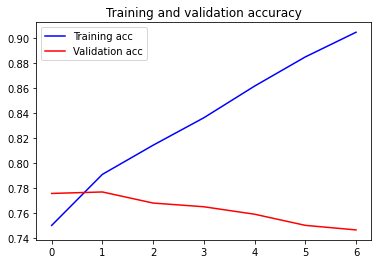

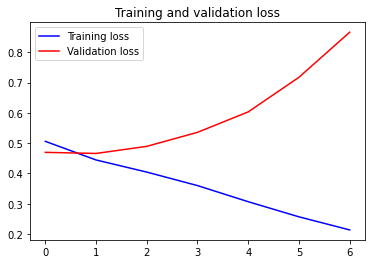

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()